## Functional responses 

We consider the following model:

\begin{align}
y_{ij} & = g(\psi_i,d_j) + \eta_{ij} + \varepsilon_{ij}, \quad \eta_{ij} \sim \mathcal{N}(0,s^2_{ij}), \quad \varepsilon_{ij} \sim \mathcal{N}(0,\sigma^2) \\
 \psi_i & = ( \lambda_i, h_i)^t, \\
 g(\psi_i,d_j) & = \frac{\sqrt{d_{j}}-1}{C_{2E}\lambda_i + h_i(\sqrt{d_{j}} - 1)} \\
 s^2_{ij} & = \frac{C_{2V}-C_{2E}^2}{\Delta} \frac{\lambda_i^2 \sqrt{d_{j}}-1}{C_{2E}\lambda_i + h_i(\sqrt{d_{j}} - 1)} \\
 \log \lambda_i & \sim \mathcal{N}(\mu_\lambda, \sigma^2_\lambda), \quad \log h_i \sim \mathcal{N}(\mu_h,\sigma^2_h) \\
\end{align}

Function $g(\psi_i,d_j)$ represents the functional response of individual $i$ at density $d_j$, based on its individual parameter values $\psi_i$, $\eta_{ij}$ represents the mecanistic noise (i.e. the intrinsic variability of the functional response process) and $\varepsilon_{ij}$ corresponds to the measurement error. We assume that $\eta_{ij}$ and $\varepsilon_{ij}$ are mutually independent.


### Adding the different sources of variabilities

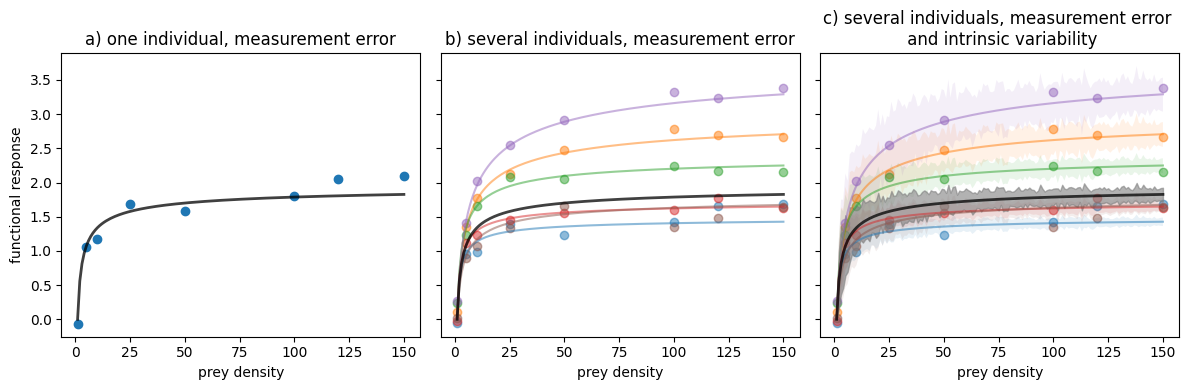

In [1]:
import config
import models
import jax.numpy as jnp
import jax
from tqdm import tqdm
import algos
import importlib
importlib.reload(models)

import matplotlib.pyplot as plt

theta_p = {"pop" : jnp.array([]), 
             "indiv" : {"mean_latent" : jnp.array([0.7,0.5]), "cov_latent" : jnp.array([[0.07,0],[0,0.05]])},
             "var_residual" : 0.1**2}
theta = models.parametrization.params_to_reals1d(theta_p)

# Test simulations
n = 6
d = jnp.array([1.1,5,10,25,50,100,120,150])
d = jnp.tile(d,(n,1))
dall = jnp.linspace(1,150,150)
dall = jnp.tile(dall,(n,1))
prng_key = 2042025
key_simu = jax.random.PRNGKey(prng_key)
z0, y, my, t, vary = models.simu_data(theta, n=n, d=d, meca_noise=0., prng_key=key_simu)
z0all, yall, myall, tall, varyall = models.simu_data(theta, n=n, d=dall, meca_noise=0., prng_key=key_simu)


Nrep = 50
key_simu = jax.random.split(key_simu,Nrep)

# Mean values
c2E = (jnp.sqrt(2) + jnp.log(1+jnp.sqrt(2)))/3
c2V = 2/3

d = jnp.array([1.1,5,10,25,50,100,120,150])
dall = jnp.linspace(1,150,150)
lam = theta_p["indiv"]["mean_latent"][0]
h = theta_p["indiv"]["mean_latent"][1]
num = d**(1/2) - 1
numall = dall**(1/2) - 1
denom = c2E * lam + num*h
denomall = c2E * lam + numall*h
varmeca = ((c2V - c2E**2)) * (lam**2*numall) / denomall**3 
rep_func_average = numall / denomall   

rep_func_mecanoise = jnp.array([rep_func_average + jax.random.normal(key=key_simu[i], shape=(1, len(dall))) * jnp.sqrt(varmeca) for i in range(Nrep)])
rep_func_mecanoise_min = jnp.min(rep_func_mecanoise,axis=0)
rep_func_mecanoise_max = jnp.max(rep_func_mecanoise,axis=0)
rep_func_one_trajectory = num/denom + jax.random.normal(key=jax.random.PRNGKey(prng_key), shape=(1, len(d))) * 0.1


# variability due to mecanistic noise for each individual
z = jnp.exp(z0all)         
lamb = z[:, 0]
h = z[:, 1]
denomall = jnp.array([c2E * lamb[i] + numall*h[i] for i in range(n)])
varmeca = jnp.array([((c2V - c2E**2)) * (lamb[i]**2*numall) / denomall[i,:]**3 for i in range(n)])
myall_mn = jnp.array([jnp.array([myall[i,:] + jax.random.normal(key=key_simu[j], shape=(1, len(dall))) * jnp.sqrt(varmeca[i,:]) for j in range(Nrep)]) for i in range(n)])
myall_mn_min = jnp.min(myall_mn,axis=1)
myall_mn_max = jnp.max(myall_mn,axis=1)


fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(12,4),sharey=True)
axs = axs.ravel()
axs[0].scatter(d,rep_func_one_trajectory)   
axs[0].plot(dall,rep_func_average,c="black",linewidth=2,alpha=0.75)
#axs[0].axhline(y=1/h,linestyle="dotted",alpha=0.85,c="black")
axs[0].set_xlabel("prey density")
axs[0].set_ylabel("functional response")
axs[0].set_title("a) one individual, measurement error")
    
for i in range(n):
    axs[1].scatter(d,y[i,:],alpha=0.5)   
    axs[1].plot(dall,myall[i,:],alpha=0.5)   
axs[1].plot(dall,rep_func_average,label=r"$\theta_1$",c="black",linewidth=2,alpha=0.75)
#axs[1].axhline(y=1/h,linestyle="dotted",alpha=0.85,c="black")
axs[1].set_xlabel("prey density")
axs[1].set_title("b) several individuals, measurement error")

for i in range(n):    
    pl, = axs[2].plot(dall,myall[i,:],alpha=0.5)
    axs[2].scatter(d,y[i,:],alpha=0.5,color=pl.get_color())    
    axs[2].fill_between(dall,myall_mn_min[i].reshape((150,)),myall_mn_max[i].reshape((150,)),alpha=0.1)
axs[2].plot(dall,rep_func_average,label=r"$\theta_1$",c="black",linewidth=2,alpha=0.75)
axs[2].fill_between(dall,rep_func_mecanoise_min.reshape((150,)),rep_func_mecanoise_max.reshape((150,)),alpha=0.6,color='grey')
#axs[2].axhline(y=1/h,linestyle="dotted",alpha=0.85,c="black")
axs[2].set_xlabel("prey density")
axs[2].set_title("c) several individuals, measurement error \n and intrinsic variability")

fig.tight_layout()
plt.savefig("ex_variability_sources.pdf")

### Generation of simulated data

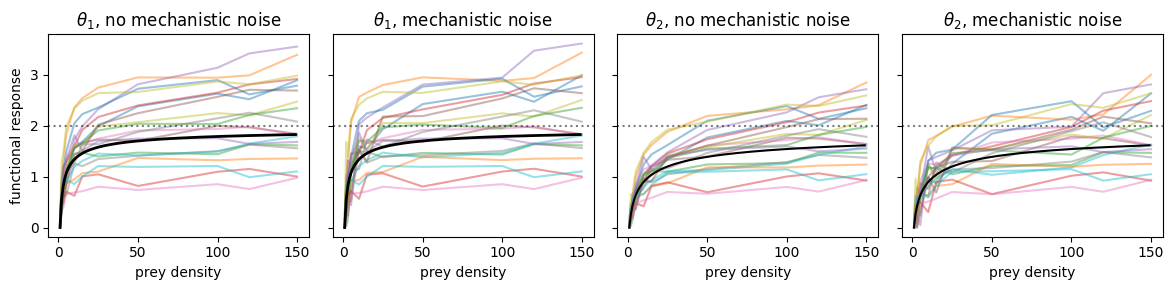

In [2]:
import importlib
importlib.reload(models)

thetatrue1 = {"pop" : jnp.array([]), 
             "indiv" : {"mean_latent" : jnp.array([0.7,0.5]), "cov_latent" : jnp.array([[0.07,0],[0,0.05]])},              
             "var_residual" : 0.1**2}
thetatrue1 = models.parametrization.params_to_reals1d(thetatrue1)


thetatrue2 = {"pop" : jnp.array([]), 
             "indiv" : {"mean_latent" : jnp.array([1.75,0.5]), "cov_latent" : jnp.array([[0.175,0],[0,0.05]])},              
             "var_residual" : 0.1**2}
thetatrue2 = models.parametrization.params_to_reals1d(thetatrue2)


thetanames = [r"$\mu_{\lambda}$",r'$\mu_h$',r'$\sigma_{\lambda}^2$',r'$\sigma_h^2$',r'$\sigma^2$']
pnames = [r"$\mu_{\lambda}$",r'$\mu_h$',r'$\sigma_{\lambda}^2$',r'$\sigma_{\lambda,h}$',r'$\sigma_h^2$',r'$\sigma^2$']

# Test simulations
n = 20
d = jnp.array([1.1,2,3,5,10,15,25,50,100,120,150])
d = jnp.tile(d,(n,1))
prng_key = 0
key_simu = jax.random.PRNGKey(prng_key)
z0, y, my, t, vary = models.simu_data(thetatrue1, n=n, d=d, meca_noise=0., prng_key=key_simu)
z02, y2, my2, t2, vary2 = models.simu_data(thetatrue2, n=n, d=d, meca_noise=0., prng_key=key_simu)

z0mn, ymn, mymn, tmn, varymn = models.simu_data(thetatrue1, n=n, d=d, meca_noise=1., prng_key=key_simu)
z02mn, y2mn, mymn2, t2mn, vary2mn = models.simu_data(thetatrue2, n=n, d=d, meca_noise=1., prng_key=key_simu)


# Mean values
c2E = (jnp.sqrt(2) + jnp.log(1+jnp.sqrt(2)))/3
c2V = 2/3

dall = jnp.arange(1,150)
num = dall**(1/2) - 1
denom = c2E * (thetatrue1[0]) + thetatrue1[1]*num
my_theta1 = num / denom   

num = dall**(1/2) - 1
denom = c2E * (thetatrue2[0]) + thetatrue2[1]*num
my_theta2 = num / denom

# plots
fig,axs = plt.subplots(nrows=1,ncols=4,figsize=(12,3),sharey=True,sharex=True)
axs = axs.ravel()
# theta1, no mecanistic noise
for i in range(n):
    axs[0].plot(d[i,:],jnp.maximum(0,y[i,:]),alpha=0.45)    
axs[0].plot(dall,my_theta1,label=r"$\theta_1$",c="black",linewidth=2)
axs[0].axhline(y=1/thetatrue1[1],linestyle="dotted",alpha=0.5,c="black")
axs[0].set_ylabel("functional response")
axs[0].set_xlabel("prey density")
axs[0].set_title(r"$\theta_1$"+", no mechanistic noise")

# theta1, mecanistic noise
for i in range(n):
    axs[1].plot(d[i,:],jnp.maximum(0,ymn[i,:]),alpha=0.45)
axs[1].plot(dall,my_theta1,label=r"$\theta_1$",c="black",linewidth=2)
axs[1].axhline(y=1/thetatrue1[1],linestyle="dotted",alpha=0.5,c="black")
axs[1].set_xlabel("prey density")
axs[1].set_title(r"$\theta_1$"+", mechanistic noise")

# theta2, no mecanistic noise
for i in range(n):
    axs[2].plot(d[i,:],jnp.maximum(0,y2[i,:]),alpha=0.45)
axs[2].plot(dall,my_theta2,label=r"$\theta_2$",c="black",linewidth=1.5)        
axs[2].axhline(y=1/thetatrue2[1],linestyle="dotted",alpha=0.5,c="black")
axs[2].set_xlabel("prey density")
axs[2].set_title(r"$\theta_2$"+", no mechanistic noise")

# theta2, mecanistic noise
for i in range(n):
    axs[3].plot(d[i,:],jnp.maximum(0,y2mn[i,:]),alpha=0.45)    
axs[3].plot(dall,my_theta2,label=r"$\theta_1$",c="black",linewidth=1.5)
axs[3].axhline(y=1/thetatrue2[1],linestyle="dotted",alpha=0.5,c="black")
axs[3].set_xlabel("prey density")
axs[3].set_title(r"$\theta_2$"+", mechanistic noise")

fig.tight_layout()
fig.savefig("ex_simudata.pdf")

### Observation scheme for each sampling size in the simulated data

Text(0.5, 0, 'prey density')

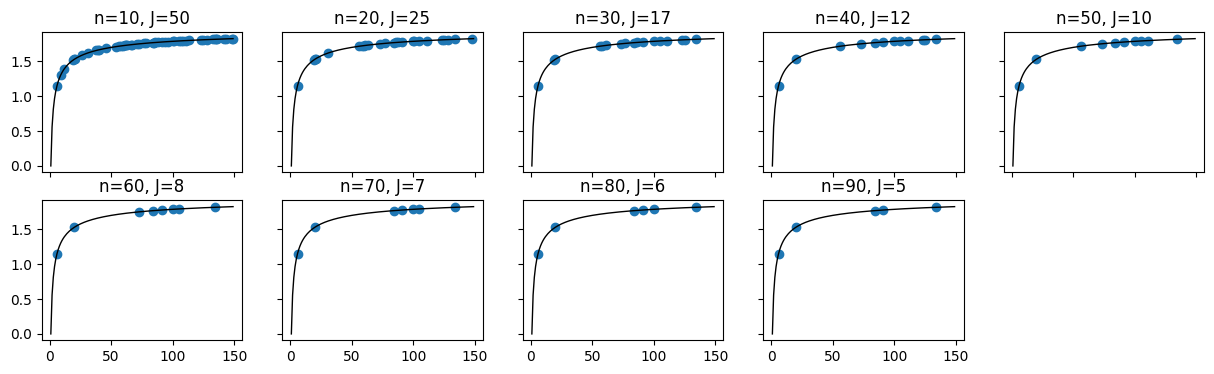

In [31]:
J_vec = jnp.array([50,25,17,12,10,8,7,6,5])
n_vec = jnp.array([10,20,30,40,50,60,70,80,90])
d_list = []

for J in J_vec:
    key_d = jax.random.PRNGKey(852018862021)
    d_list.append(jnp.sort(jax.random.choice(key_d,jnp.arange(1,150),shape=(1,J),replace=False)))
  
d_list

# plots
fig,axs = plt.subplots(nrows=2,ncols=5,figsize=(15,4),sharey=True,sharex=True)
axs = axs.ravel()
for i in range(len(d_list)):
    ind_i = jnp.searchsorted(dall,d_list[i]) 
    axs[i].scatter(d_list[i],my_theta1[ind_i])
    axs[i].plot(dall,my_theta1,c="black",linewidth=1)
    axs[i].set_title("n="+str(n_vec[i])+", J="+str(J_vec[i]))
axs[9].set_axis_off()
plt.ylabel("functional response")
plt.xlabel("prey density")


### Run the algorithm for several values of the step size

In [4]:
import importlib

n_preheating = 500
n_iter = 3500

key = jax.random.PRNGKey(0)
thetainit = jax.random.uniform(key=key, shape=(models.parametrization.size,), minval=0.6, maxval=1.4)*thetatrue1       

# without mecanistic noise
res_step1 = algos.fisher_sgd(y=y,d=d,delta=1,meca_noise=0,dim=2,prng_key=prng_key,pre_heating=n_preheating,Nmax=n_iter,theta0=thetainit,optim_step='AdaGrad',factor=1)
res_step2 = algos.fisher_sgd(y=y,d=d,delta=1,meca_noise=0,dim=2,prng_key=prng_key,pre_heating=n_preheating,Nmax=n_iter,theta0=thetainit,optim_step='AdaGrad',factor=0.35)
res_step3 = algos.fisher_sgd(y=y,d=d,delta=1,meca_noise=0,dim=2,prng_key=prng_key,pre_heating=n_preheating,Nmax=n_iter,theta0=thetainit,optim_step='AdaGrad',factor=0.05)    

# with mecanistic noise
resmn_step1 = algos.fisher_sgd(y=ymn,d=d,delta=1,meca_noise=1,dim=2,prng_key=prng_key,pre_heating=n_preheating,Nmax=n_iter,theta0=thetainit,optim_step='AdaGrad',factor=1)
resmn_step2 = algos.fisher_sgd(y=ymn,d=d,delta=1,meca_noise=1,dim=2,prng_key=prng_key,pre_heating=n_preheating,Nmax=n_iter,theta0=thetainit,optim_step='AdaGrad',factor=0.35)
resmn_step3 = algos.fisher_sgd(y=ymn,d=d,delta=1,meca_noise=1,dim=2,prng_key=prng_key,pre_heating=n_preheating,Nmax=n_iter,theta0=thetainit,optim_step='AdaGrad',factor=0.05)    

100%|██████████| 3500/3500 [00:10<00:00, 319.41it/s]


We can monitor the convergence of the algorithm by plotting the evolution of the parameter estimates along the iterations of the algorithm. 

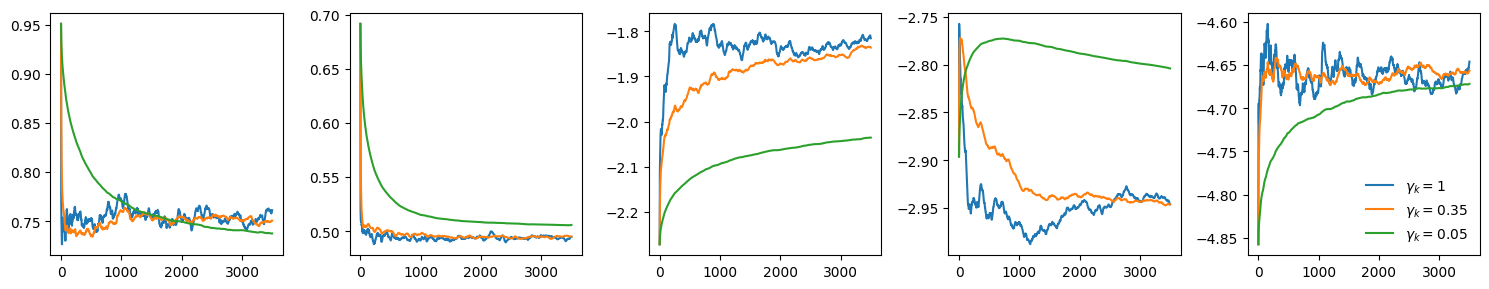

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=False, figsize=(15,3))    
ax = ax.ravel()
for i in range(5):    
    ax[i].plot(res_step1.theta[:,i],label=r"$\gamma_k=1$")
    ax[i].plot(res_step2.theta[:,i],label=r"$\gamma_k=0.35$")
    ax[i].plot(res_step3.theta[:,i],label=r"$\gamma_k=0.05$")
ax[4].legend(frameon=False)
fig.tight_layout()
plt.savefig("ex_convergence.pdf")

We can do the same with the parameter values transformed back into their original scale.

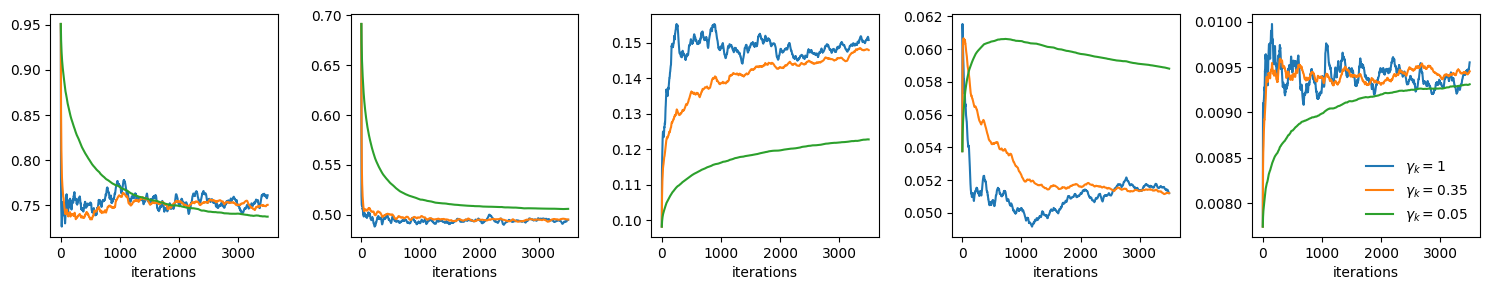

In [7]:
# transform unconstrained parameters back into their original scale
params_step1 = [models.parametrization.reals1d_to_params(x) for x in res_step1.theta]
params_step2 = [models.parametrization.reals1d_to_params(x) for x in res_step2.theta]
params_step3 = [models.parametrization.reals1d_to_params(x) for x in res_step3.theta]

# reshape to get an array
params_step1 = jnp.array([jnp.concatenate((p.indiv.mean_latent.reshape(2,),jnp.diag(p.indiv.cov_latent),p.var_residual.reshape(1,))) for p in params_step1])
params_step2 = jnp.array([jnp.concatenate((p.indiv.mean_latent.reshape(2,),jnp.diag(p.indiv.cov_latent),p.var_residual.reshape(1,))) for p in params_step2])
params_step3 = jnp.array([jnp.concatenate((p.indiv.mean_latent.reshape(2,),jnp.diag(p.indiv.cov_latent),p.var_residual.reshape(1,))) for p in params_step3])

fig, ax = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=False, figsize=(15,3))    
ax = ax.ravel()
for i in range(5):    
    ax[i].plot(params_step1[:,i],label=r"$\gamma_k=1$")
    ax[i].plot(params_step2[:,i],label=r"$\gamma_k=0.35$")
    ax[i].plot(params_step3[:,i],label=r"$\gamma_k=0.05$")    
    ax[i].set_xlabel("iterations")
ax[4].legend(frameon=False)
fig.tight_layout()
plt.savefig("ex_convergence.pdf")